## 01. Trabalho Final
#### Dupla: Hélio Potelicki e Rennã Murilo Tiedt

In [1]:
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
import plotly.express as px
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import os

In [2]:
dataset_path = "W:/CODANDO/FURB/FURB_AULAS/7 - Semestre/Processamento de Imagens/Trabalho Final/Classificador-de-figuras-musicais/database/"
df = pd.DataFrame(columns=["x_train", "y_train"])

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        if filename.endswith(".jpg"):
            image = np.asarray(Image.open((f"{root}/{filename}")))

            label = root.split("/")[-1]
            row = [image, label]
            df.loc[len(df)] = row

df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)
df.head()

,x_train,y_train
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2
1,"[[[253, 253, 253], [253, 253, 253], [253, 253,...",4
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,"[[[253, 253, 253], [253, 253, 253], [253, 253,...",1
4,"[[[253, 253, 253], [253, 253, 253], [253, 253,...",2


In [3]:
# Train
x_train = df.iloc[:3000, 0:1].to_numpy()
x_train = np.array([img[0] for img in x_train])

y_train = df.iloc[:3000, 1:2]
y_train = tf.strings.to_number(y_train, out_type=tf.int32)
y_train = tf.one_hot(y_train, depth=5)
y_train = tf.squeeze(y_train)

# Test
x_test = df.iloc[3000:, 0:1].to_numpy()
x_test = np.array([img[0] for img in x_test])

y_test = df.iloc[3000:, 1:2]
y_test = tf.strings.to_number(y_test, out_type=tf.int32)
y_test = tf.one_hot(y_test, depth=5)
y_test = tf.squeeze(y_test)

In [4]:
print(x_train.dtype)
print(x_train.shape)
print("")
print(y_train.dtype)
print(y_train.shape)
print("")
print(x_test.dtype)
print(x_test.shape)
print("")
print(y_test.dtype)
print(y_test.shape) 

uint8
(3000, 64, 64, 3)

<dtype: 'float32'>
(3000, 5)

uint8
(2000, 64, 64, 3)

<dtype: 'float32'>
(2000, 5)


In [9]:
filename='model.h5'

def model():
    model = Sequential()

    model.add(Conv2D(30, (5, 5), input_shape=(64, 64, 3), activation='relu'))
    model.add(Conv2D(30, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(5, activation='softmax', name='predict'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [10]:
model = model()
model.summary()

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=9, batch_size=100)
model.save(filename)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 30)        2280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 30)        22530     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 15)        4065      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 15)        2040      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 15)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 15)       

In [7]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("\nACC: %.2f%%" % (scores[1]*100))


ACC: 99.45%


In [11]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
dfp = pd.DataFrame()
dfp['Loss'] = history.history['loss']
dfp['Val_Loss'] = history.history['val_loss']

In [12]:
fig = px.line(dfp, x=dfp.index, y='Loss')
fig.update_layout(xaxis_title="Epochs", yaxis_title="Loss", width=800, height=400)
fig.show()

Figura de uma Minima, com confiança de 26.16%


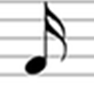

In [14]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
image_test = 'test/semicolcheia.png'

def load_image(img_path):
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(64, 64))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.                                    

    return img_tensor

model = load_model('model.h5')

new_image = load_image(image_test)
pred = model.predict_classes(new_image)
pred_proba = model.predict_proba(new_image)
pred_proba = f"{(float(pred_proba[0][pred]) * 100):.2f}%"
fig_dict = {0:"Colcheia", 1:"Minima", 2:"Semibreve", 3:"Semicolcheia", 4:"Seminima"}

print(f"Figura de uma {fig_dict[pred[0]]}, com confiança de {pred_proba}")
img = Image.open(image_test)
img